# LSTM Implementation - AAPL data

**Notebook Summary**


**Granularity**: daily data

**Source**: Yahoo! Finance

**Time period**: 2010-01-04 / 2022-12-30

**Model**: LSTM

#Importing libraries

In [ ]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import io
import math
import pandas as pd
import numpy as np
import datetime

# Keras
import keras
from keras.layers import *
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

# Sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load data


In [ ]:
# Import raw data
data = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']) , index_col = 'Date', parse_dates = True) 

# Exploratory analysis

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516528,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401018,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443573,447610800


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3272 non-null   float64
 1   High       3272 non-null   float64
 2   Low        3272 non-null   float64
 3   Close      3272 non-null   float64
 4   Adj Close  3272 non-null   float64
 5   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.9 KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3.272000e+03
mean,51.297746,51.869747,50.731996,51.321186,49.394303,2.562707e+08
std,47.328490,47.938843,46.732224,47.357062,47.751072,2.225648e+08
min,6.870357,7.000000,6.794643,6.858929,5.837761,3.519590e+07
25%,18.966697,19.121697,18.780178,18.967590,16.600964,1.023541e+08
50%,29.756251,29.981250,29.561250,29.814999,27.344628,1.666698e+08
75%,56.983748,57.309998,56.469999,56.777499,54.869695,3.456643e+08
max,182.630005,182.940002,179.119995,182.009995,180.683868,1.880998e+09


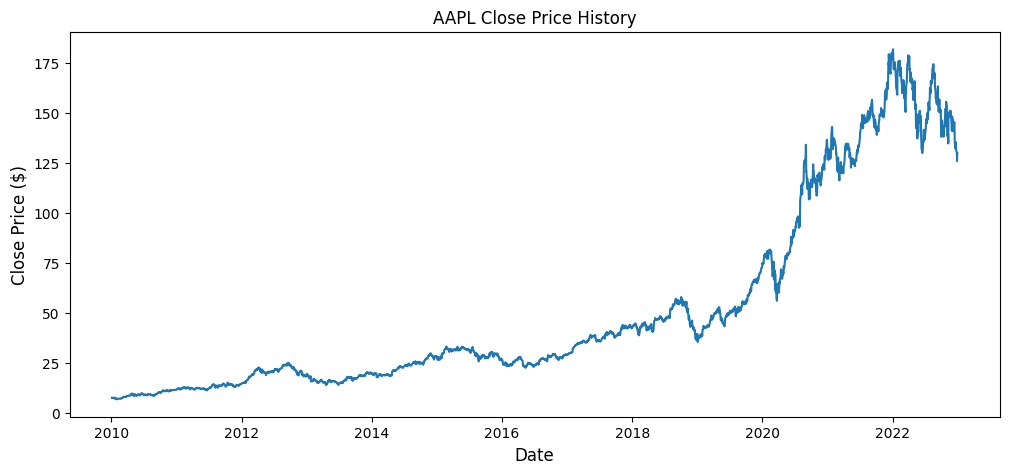

In [ ]:
# Plot the closing price
plt.figure(figsize=(12,5))
plt.title('AAPL Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price ($)', fontsize = 12)
plt.show()

In [ ]:
# Create a new feature
log_returns = np.log(data["Adj Close"]).diff(1) 
data["log_returns"] = log_returns 

In [ ]:
# Refine the dataset
data = data[["log_returns"]]

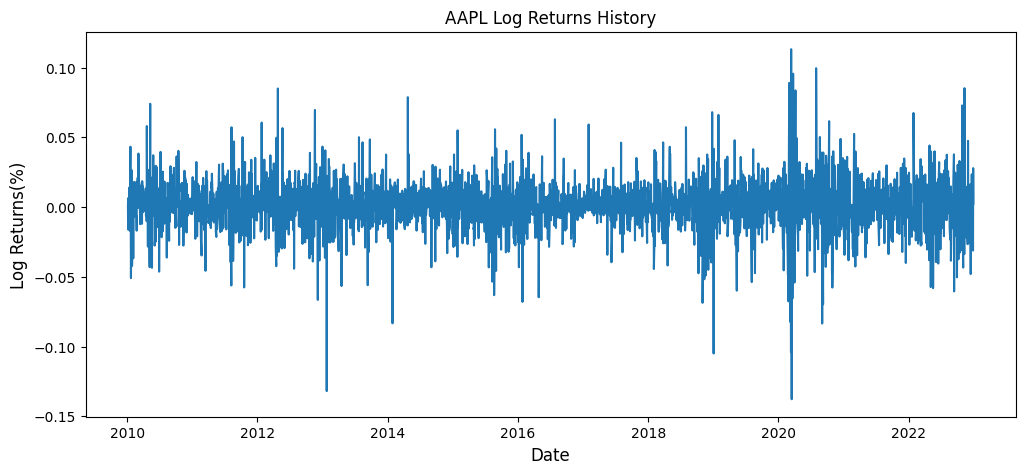

In [ ]:
# Plot the log returns
plt.figure(figsize=(12,5))
plt.title('AAPL Log Returns History')
plt.plot(data)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Log Returns(%)', fontsize = 12)
plt.show()

In [ ]:
# Drop the first row containing a NaN value
data = data[1:]
data

,log_returns
Date,
2010-01-05,0.001728
2010-01-06,-0.016034
2010-01-07,-0.001850
2010-01-08,0.006626
2010-01-11,-0.008861
...,...
2022-12-23,-0.002802
2022-12-27,-0.013976
2022-12-28,-0.031166


#Data processing

### Train-Test split

In [ ]:
# Train and test split
ratio = 0.8
train_size = int(len(data)* ratio) 
train_data = data[:train_size]
test_data = data[train_size:]

### Building input features

In [ ]:
# Define the look-back and look-forward variables
look_back = 60  
look_forward = 7  

In [ ]:
# Convert an array of values into a dataset matrix

def create_features(data, look_back=60, look_forward=7):
    dataX, dataY = [], []
    np.array(dataY)
    for k in range(len(data)-look_back-1):
        a = data[k:(k + look_back), 0]
        if len(data[k + look_back: k + look_back + look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(data[k + look_back: k + look_back + look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Generate train X and train Y data
trainX, trainY = create_features(train_data.values, look_back, look_forward)

In [ ]:
# Generate test X and test Y data
testX, testY = create_features(test_data.values, look_back, look_forward)

###Reshape to 3D data

In [ ]:
# Reshape input to be (samples, time steps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2550, 60, 1)
(2550, 7)
(589, 60, 1)
(589, 7)


#LSTM Model Builder

In [ ]:
# Create a function that build an LSTM 

def create_lstm(input_shape = (look_back, 1), lstm_units=128, dense_units=7, drop_rate = 0.1):
    # Initialising the LSTM
    model = Sequential()

    # Adding the LSTM layer and some dropout regularization
    model.add(LSTM(units=lstm_units, input_shape=input_shape, stateful=False))
    model.add(Dropout(rate = drop_rate))

    # Adding a Dense layer
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= dense_units))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
    return model


In [ ]:
# Instantiate an LSTM model to wrap in KerasRegressor
lstm = KerasRegressor(build_fn = create_lstm, verbose=0)

# Block Time Series Split and GridSearch CV

In [ ]:
# Define a Block Time Series Split (no overlapping data)
class BlockTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            end = start + k_fold_size
            mid = int(0.5 * (end - start)) + start
            yield indices[start: mid], indices[mid + margin: end]

In [ ]:
# Define the number of splits and get some metrics
btscv = BlockTimeSeriesSplit(n_splits= 12)

###Define the parameters to tune

In [ ]:
# Define the parameter grid for GridSearch
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 15, 20],
    'drop_rate' : [0.1, 0.15],
    'dense_units': [7],
    'lstm_units':[64, 128, 256]}

###Run GridSearchCV

In [ ]:
# Create the GridSearchCV object with BlockTimeSeriesSplit
#grid_search = GridSearchCV(estimator = lstm, param_grid = param_grid, cv = btscv, scoring = 'neg_mean_squared_error')

In [ ]:
# Fit the data to the GridSearchCV object
#grid_result = grid_search.fit(trainX, trainY)

In [ ]:
# Access the best parameters and best score
#best_params = grid_result.best_params_
#best_score = grid_result.best_score_
#print("Best parameters:", best_params)
#print("Best score:" , best_score)

# Fit the best model

In [ ]:
# Store the best_params dictionary to avoid re-running GridSearch
best_params = {'batch_size': 64, 'dense_units': 7, 'drop_rate': 0.1, 'epochs': 15, 'lstm_units': 128}

In [ ]:
# Use the best parameters to create the LSTM model
model = create_lstm(lstm_units =best_params['lstm_units'], dense_units= best_params['dense_units'] , drop_rate = best_params['drop_rate'])

In [ ]:
# Fitting the model
history = model.fit(trainX, trainY, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/15
40/40 [==============================] - 9s 118ms/step - loss: 3.3660e-04 - accuracy: 0.1349
Epoch 2/15
40/40 [==============================] - 9s 213ms/step - loss: 3.1228e-04 - accuracy: 0.1380
Epoch 3/15
40/40 [==============================] - 6s 146ms/step - loss: 3.1187e-04 - accuracy: 0.1463
Epoch 4/15
40/40 [==============================] - 5s 117ms/step - loss: 3.1120e-04 - accuracy: 0.1522
Epoch 5/15
40/40 [==============================] - 6s 139ms/step - loss: 3.1333e-04 - accuracy: 0.1404
Epoch 6/15
40/40 [==============================] - 4s 99ms/step - loss: 3.1145e-04 - accuracy: 0.1435
Epoch 7/15
40/40 [==============================] - 4s 96ms/step - loss: 3.0811e-04 - accuracy: 0.1384
Epoch 8/15
40/40 [==============================] - 6s 148ms/step - loss: 3.0837e-04 - accuracy: 0.1502
Epoch 9/15
40/40 [==============================] - 4s 96ms/step - loss: 3.1241e-04 - accuracy: 0.1396
Epoch 10/15
40/40 [==============================] - 4s 93ms/step -

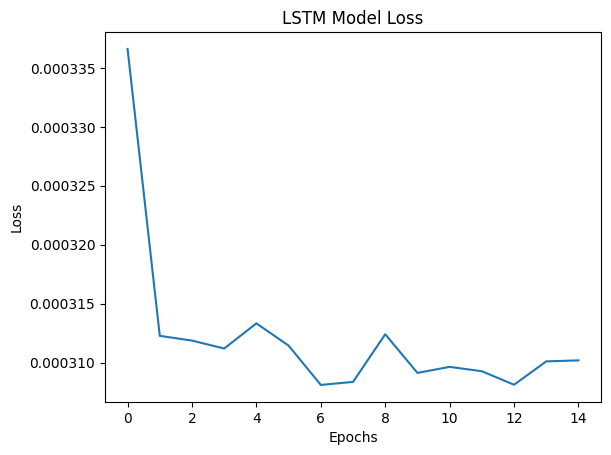

In [ ]:
# Plot the loss over the epochs
plt.plot(history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Predict the model using test X data
y_pred = model.predict(testX)

19/19 [==============================] - 2s 50ms/step


In [ ]:
# Get a sense of how y_pred looks like
y_pred

array([[0.00391712, 0.00380265, 0.00323358, ..., 0.00154317, 0.00176869,
        0.00474096],
       [0.00319318, 0.00366504, 0.00309088, ..., 0.00145428, 0.00155424,
        0.00513728],
       [0.00342272, 0.00373012, 0.00313239, ..., 0.00150855, 0.00166747,
        0.00503497],
       ...,
       [0.00523851, 0.00395413, 0.00340726, ..., 0.00155578, 0.00191945,
        0.00385194],
       [0.00520596, 0.00392781, 0.00339645, ..., 0.00152555, 0.00186708,
        0.0038417 ],
       [0.00489861, 0.00385062, 0.00332998, ..., 0.00146296, 0.00173614,
        0.00398237]], dtype=float32)

In [ ]:
print(y_pred.shape)

(589, 7)


###Compute the MSE and RMSE

In [ ]:
mse = mean_squared_error(testY, y_pred)
rmse = math.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

0.020604601577977364

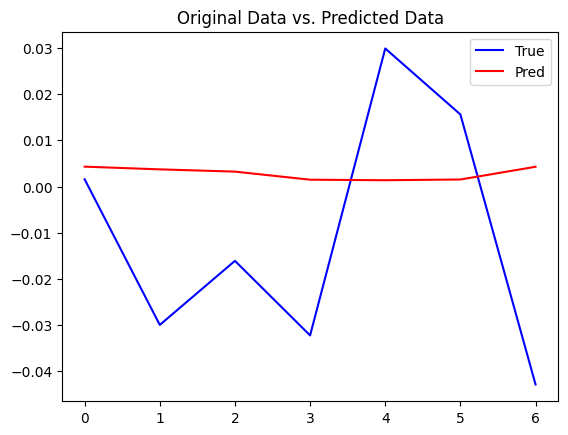

In [ ]:
# Plot one prediction against test data
plt.plot(testY[16], color = "b", label = "True")
plt.plot(y_pred[16], color = "r", label = "Pred")
plt.title('Original Data vs. Predicted Data')
plt.legend()
plt.show()

# Get a single prediction

In [ ]:
# Get a single observation
single = testX[550].reshape(1, testX[550].shape[0], testX[550].shape[1])
single.shape

(1, 60, 1)

In [ ]:
# Make a prediction
single_pred = model.predict(single)

1/1 [==============================] - 0s 24ms/step


In [ ]:
single_pred

array([[0.00429751, 0.00386391, 0.00325149, 0.00173742, 0.00156307,
        0.00183167, 0.00449969]], dtype=float32)

In [ ]:
single_pred.shape

(1, 7)

In [ ]:
# Get the corresponding test array
single_test = testY[550].reshape(1, testY.shape[1])
single_test.shape

(1, 7)

###Compute the MSE

In [ ]:
mse = mean_squared_error(single_test, single_pred)
mse

0.0014824259468669727

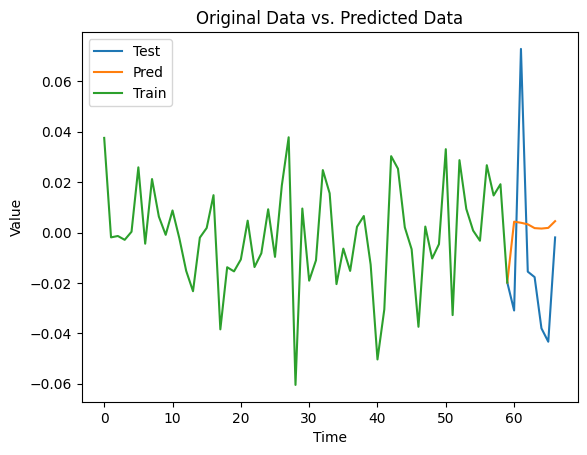

In [ ]:
# Plot
plt.plot(list(range(59,67)), np.insert(single_test.reshape(7,), 0, single[0,59,0]), label='Test')
plt.plot(list(range(59,67)), np.insert(single_pred.reshape(7,), 0, single[0,59,0]), label='Pred')
plt.plot(list(range(0,60)), single.reshape(60,), label='Train')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data vs. Predicted Data')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Plot all the predictions

In [ ]:
# Indexing data 
times_exploded = []
forecast_len = testY.shape[1]
idx_list = data.index.to_list()

for i in range(len(data.index) - forecast_len):
  times_exploded.append(pd.to_datetime(idx_list[i : i + forecast_len]))

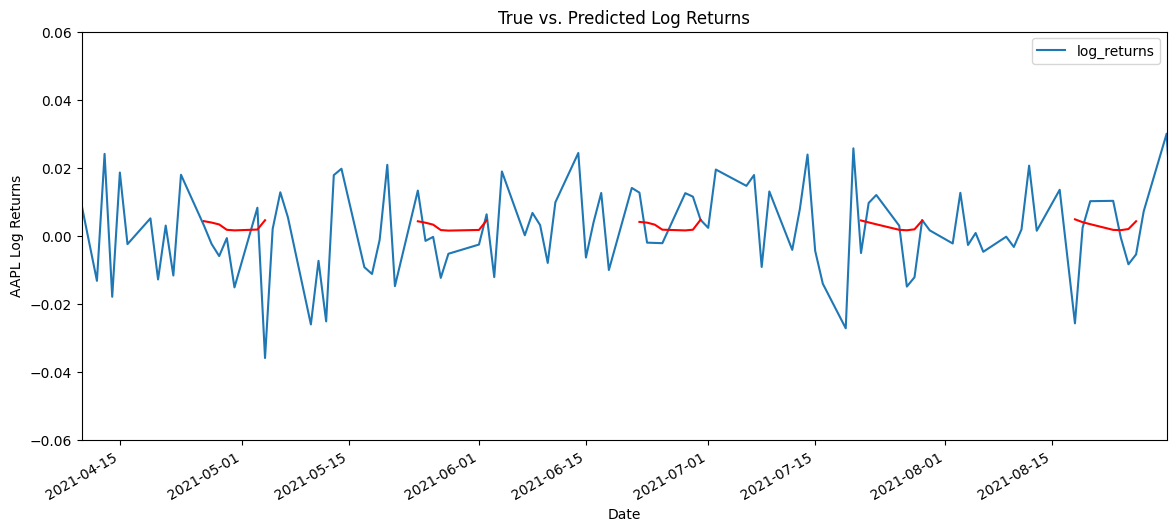

In [ ]:
# Plot the log returns


# Define dates
start_time = pd.to_datetime("2021-04-10")
end_time = pd.to_datetime("2021-08-30")

# Adjust x-axis limits
ax = (data.iloc[-len(y_pred):]).plot(
    style="-",
    title="True vs. Predicted Log Returns",
    xlabel="Date",
    ylabel="AAPL Log Returns",
    xlim=[start_time, end_time],
    ylim =[-0.06, 0.06],
    figsize=(14, 6))

times = times_exploded[-len(y_pred):]
for idx in range(10, len(y_pred), 20):
  plt.plot(times[idx], y_pred[idx], color = 'r')

# Add legend 
ax.legend()